In [22]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tsdb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
sys.path.append('/home/stelios-pc/Desktop/PhD/Pandora/Halcor/')
from dataset import Dataset
from pygrinder import mcar, seq_missing, block_missing
from pypots.optim import Adam
from pypots.imputation import USGAN

data = Dataset('1d')
data = data.preprocess()

def impute(data, time_steps, batch_size, epochs, is_test = False, d_steps = 5):
    def create_missingness(X, rate, pattern, **kwargs):
        """Create missingness in the data.

        Parameters
        ----------
        X:
            The input data.

        rate:
            The missing rate.

        pattern:
            The missing pattern to apply to the dataset.
            Must be one of ['point', 'subseq', 'block'].

        Returns
        -------

        """
        supported_missing_pattern = ["point", "subseq", "block"]

        assert 0 < rate < 1, "rate must be in [0, 1)"
        assert (
            pattern.lower() in supported_missing_pattern
        ), f"pattern must be one of {supported_missing_pattern}, but got {pattern}"

        if pattern == "point":
            return mcar(X, rate)
        elif pattern == "subseq":
            return seq_missing(X, rate, **kwargs)
        elif pattern == "block":
            return block_missing(X, factor=rate, **kwargs)
        else:
            raise ValueError(f"Unknown missingness pattern: {pattern}")


    holdout_data = data.copy()
    data.drop(columns='Timestamp', inplace=True)
    # X = data.drop(columns='diff')
    print(data.shape)
    original_df = data
    # Y = data['diff']

    if is_test:
        train_X, test_X = train_test_split( data, test_size=0.2)
        train_X, val_X = train_test_split( train_X, test_size=0.2)
        train_X, val_X, test_X = train_X.to_numpy(), val_X.to_numpy(), test_X.to_numpy()
    else:
        # no test set, just train/val
        train_X, val_X = train_test_split( data, test_size=0.2)
        train_X, val_X = train_X.to_numpy(), val_X.to_numpy()

    # normalization
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_X)
    val_X = scaler.transform(val_X)
    if is_test:
        test_X = scaler.transform(test_X)

    data_truncated = train_X[:(train_X.shape[0] // time_steps) * time_steps, :]
    train_X = data_truncated.reshape((train_X.shape[0] // time_steps), time_steps, -1)


    data_truncated = val_X[:(val_X.shape[0] // time_steps) * time_steps, :]
    val_X = data_truncated.reshape((val_X.shape[0] // time_steps), time_steps, -1)

    if is_test:
        data_truncated = test_X[:(test_X.shape[0] // time_steps) * time_steps, :]
        saved_orig_test = test_X
        test_X = data_truncated.reshape((test_X.shape[0] // time_steps), time_steps, -1)


    processed_dataset = {
            # general info
            # "n_classes": 2,
            "n_steps": time_steps,
            "n_features": train_X.shape[-1],
            "scaler": scaler,
            # train set
            "train_X": train_X,
            # "train_y": train_Y,
            # "train_ICUType": train_ICUType.flatten(),
            # val set
            "val_X": val_X,
            # "val_y": val_Y,
            # "val_ICUType": val_ICUType.flatten(),
            # test set
            "test_X": test_X if is_test else None,
            # "test_y": test_Y if is_test else None,
            # "test_ICUType": test_ICUType.flatten(),
        }

    # hold out ground truth in the original data for evaluation
    val_X_ori = val_X
    if is_test:
        test_X_ori = test_X
    # mask values in the validation set as ground truth
    val_X = create_missingness(val_X, 0.1, 'point')
    
    processed_dataset["train_X"] = train_X
    processed_dataset["val_X"] = val_X
    processed_dataset["val_X_ori"] = val_X_ori
    val_X_indicating_mask = np.isnan(val_X_ori) ^ np.isnan(val_X)
    if is_test:
        # mask values in the test set as ground truth
        test_X = create_missingness(test_X, 0.1, 'point')
        processed_dataset["test_X"] = test_X
        processed_dataset["test_X_ori"] = test_X_ori
        test_X_indicating_mask = np.isnan(test_X_ori) ^ np.isnan(test_X)

    # Assemble the datasets for training, validating, and testing.

    dataset_for_training = {
        "X": processed_dataset['train_X'],
    }

    dataset_for_validating = {
        "X": processed_dataset['val_X'],
        "X_ori": processed_dataset['val_X_ori'],
    }

    if is_test:
        dataset_for_testing = {
            "X": processed_dataset['test_X'],
        }

    # initialize the model
    us_gan = USGAN(
        n_steps=processed_dataset['n_steps'],
        n_features=processed_dataset['n_features'],
        rnn_hidden_size=512,
        lambda_mse=1,
        dropout=0.3,
        G_steps=1,
        D_steps=d_steps,
        batch_size=batch_size,
        # here we set epochs=10 for a quick demo, you can set it to 100 or more for better performance
        epochs=epochs,
        # here we set patience=3 to early stop the training if the evaluting loss doesn't decrease for 3 epoches.
        # You can leave it to defualt as None to disable early stopping.
        patience=10,
        # give the optimizer. Different from torch.optim.Optimizer, you don't have to specify model's parameters when
        # initializing pypots.optim.Optimizer. You can also leave it to default. It will initilize an Adam optimizer with lr=0.001.
        G_optimizer=Adam(lr=1e-3),
        D_optimizer=Adam(lr=1e-3),
        # this num_workers argument is for torch.utils.data.Dataloader. It's the number of subprocesses to use for data loading.
        # Leaving it to default as 0 means data loading will be in the main process, i.e. there won't be subprocesses.
        # You can increase it to >1 if you think your dataloading is a bottleneck to your model training speed
        num_workers=0,
        # just leave it to default as None, PyPOTS will automatically assign the best device for you.
        # Set it as 'cpu' if you don't have CUDA devices. You can also set it to 'cuda:0' or 'cuda:1' if you have multiple CUDA devices, even parallelly on ['cuda:0', 'cuda:1']
        device=None,
        # set the path for saving tensorboard and trained model files 
        saving_path="tutorial_results/imputation/us_gan",
        # only save the best model after training finished.
        # You can also set it as "better" to save models performing better ever during training.
        model_saving_strategy="best",
    )

    # train the model on the training set, and validate it on the validating set to select the best model for testing in the next step
    us_gan.fit(train_set=dataset_for_training, val_set=dataset_for_validating)

    original_df = original_df.to_numpy()
    original_df = scaler.transform(original_df)
    data_truncated = original_df[:(original_df.shape[0] // time_steps) * time_steps, :]
    original_df = data_truncated.reshape((original_df.shape[0] // time_steps), time_steps, -1)
    original_df.shape

    # the testing stage, impute the originally-missing values and artificially-missing values in the test set
    dataset_for_testing = {
        "X": original_df,
    }
    us_gan_results = us_gan.predict(dataset_for_testing)
    us_gan_imputation = us_gan_results["imputation"]

    us_gan_imputation = us_gan_imputation.reshape(-1, processed_dataset['n_features'])
    us_gan_imputation = scaler.inverse_transform(us_gan_imputation)

    print(us_gan_imputation.shape)
    df = pd.DataFrame(us_gan_imputation, columns= holdout_data.columns[1:])
    df = pd.concat([pd.Series(holdout_data['Timestamp'], name='Timestamp'),
                        df], axis=1)

    plt.figure(figsize=(20, 6))

    # plt.plot(data['Timestamp'][:100], df['DB   10DBW    2   main pressure'][:100], label='imputed Diff')
    # plt.plot(data['Timestamp'][:100], data['DB   10DBW    2   main pressure'][:100], label='origin Diff')
    plt.plot(holdout_data['Timestamp'], df['DB   10DBW  196  hp pressure pump'], label='imputed Diff')
    plt.plot(holdout_data['Timestamp'], holdout_data['DB   10DBW  196  hp pressure pump'], label='origin Diff')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Diff')
    plt.title('Diff origin VS imputed')
    plt.xticks(rotation=45)
    plt.show()

    df.to_csv('imputed_data.csv', index=False)

/home/stelios-pc/Desktop/PhD/Pandora/Halcor/dataset.py:138: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so later can be filled with 'fillna' later
/home/stelios-pc/Desktop/PhD/Pandora/Halcor/dataset.py:138: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so later can be filled with 'fillna' later
/home/stelios-pc/Desktop/PhD/Pandora/Halcor/dataset.py:138: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so later can be filled with 'fillna' later
/home/stelios-pc/Desktop/PhD/Pandora/Halcor/dataset.py:138: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - 

2025-01-06 16:44:08 [INFO]: No given device, using default device: cuda
2025-01-06 16:44:08 [INFO]: Model files will be saved to tutorial_results/imputation/us_gan/20250106_T164408
2025-01-06 16:44:08 [INFO]: Tensorboard file will be saved to tutorial_results/imputation/us_gan/20250106_T164408/tensorboard
2025-01-06 16:44:08 [INFO]: USGAN initialized with the given hyperparameters, the number of trainable parameters: 4,215,086
2025-01-06 16:44:09 [INFO]: Epoch 001 - generator training loss: 0.7858, discriminator training loss: 0.6899, validation loss: 0.9619
2025-01-06 16:44:09 [INFO]: Epoch 002 - generator training loss: 0.7320, discriminator training loss: 0.6540, validation loss: 0.9467
2025-01-06 16:44:09 [INFO]: Epoch 003 - generator training loss: 0.6733, discriminator training loss: 0.6218, validation loss: 0.9327
2025-01-06 16:44:10 [INFO]: Epoch 004 - generator training loss: 0.5981, discriminator training loss: 0.5998, validation loss: 0.9151
2025-01-06 16:44:10 [INFO]: Epoch

(320, 30)


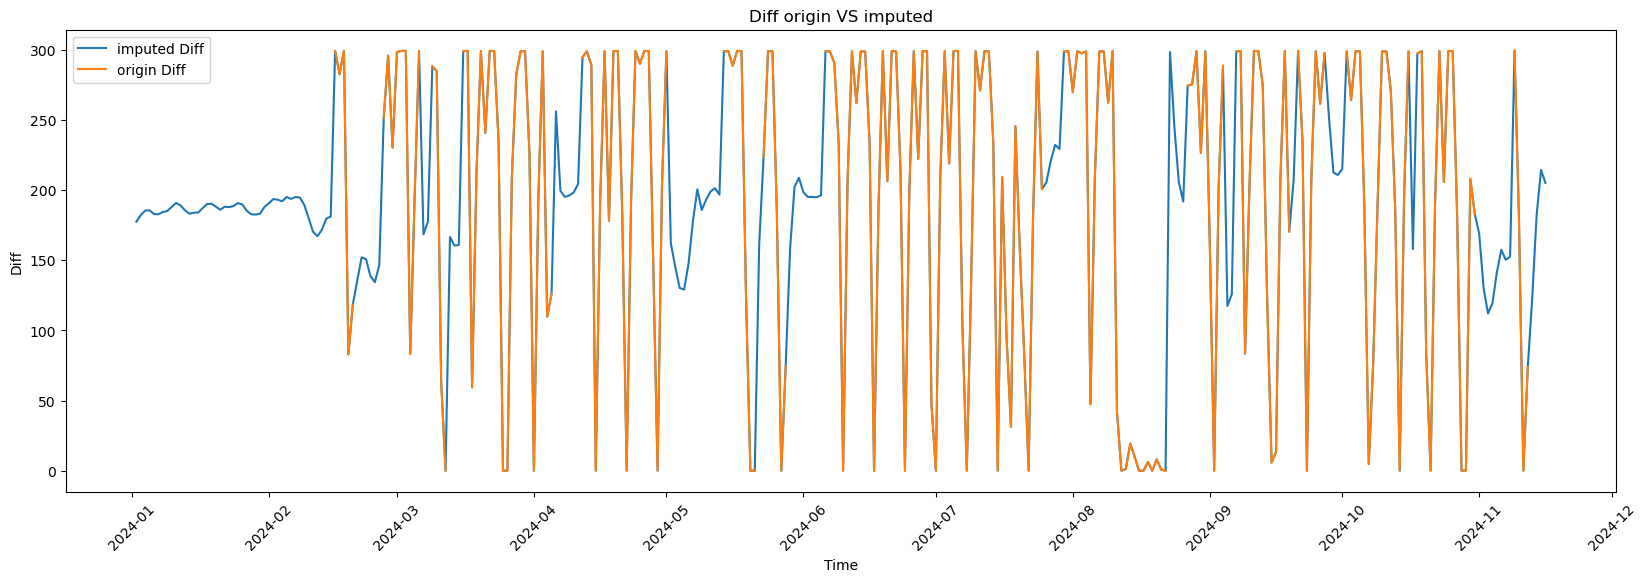

In [23]:
impute(data, 64, 64, 100)

In [24]:
data.shape

(348, 30)